In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from spike_training import *
from rate_training import *

In [14]:
n_par, time_par, train_par, conn_par, run_par = create_default_params()

In [15]:
def gen_rand_stim(n_par, time_par):
    N = n_par['net_size']
    dt = time_par['dt']
    timesteps = int(time_par['total_time']/dt)
    
    stim = np.zeros((N, timesteps))
    for row in range(N):
        rstim = 2 * sp.stats.uniform.rvs(0, 1) - 1 # random stim weight from -1, 1
        stim[row][int(time_par['stim_on']/dt):int(time_par['stim_off']/dt)] = rstim
    return stim

In [16]:
stim = gen_rand_stim(n_par, time_par)

In [17]:
# fout, driving stim set to our data
timesteps = int(time_par['total_time']/time_par['dt'])
N = n_par['net_size']
raw_waveforms = np.transpose(np.load("raw_form.npy"))
fout = raw_waveforms[0][0:timesteps]
inp_w = sp.stats.uniform.rvs(size = N)
fdrive = np.outer(inp_w, fout)

In [18]:
rtrainer = rate_training(n_par, time_par, train_par, conn_par, run_par)

In [20]:
x = rtrainer.run_rate(run_par, stim, fdrive)

Text(0.5, 1.0, 'Sample driven neuronal behavior')

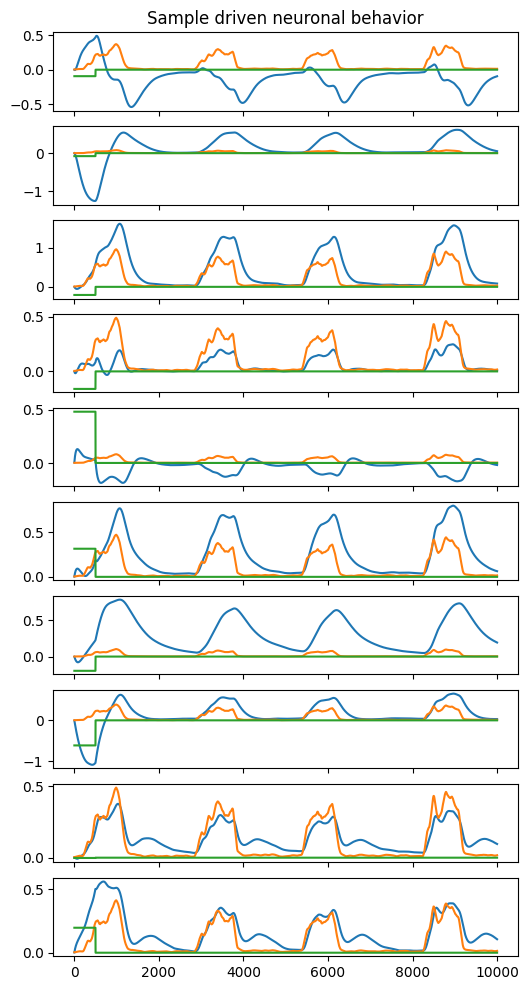

In [21]:
n_plot = 10

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(x[i])
    axs[i].plot(fdrive[i])
    axs[i].plot(stim[i])

axs[0].set_title("Sample driven neuronal behavior")

In [ ]:
# generate auxillary targets
# internal activity plus external activity

aux_targs = x + fdrive

In [12]:
W_trained = rtrainer.W_trained

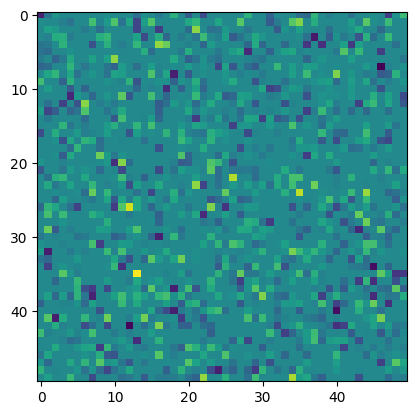

In [13]:
plt.imshow(W_trained)

In [13]:
W_trained, spks_t, sdrive_t, thetas_t, spk_rast_t = train_QIF(neuron_params, time_params, train_params, W_trained, fin, aux_targs)

0
1
2
3
4
5
6
7
8
9


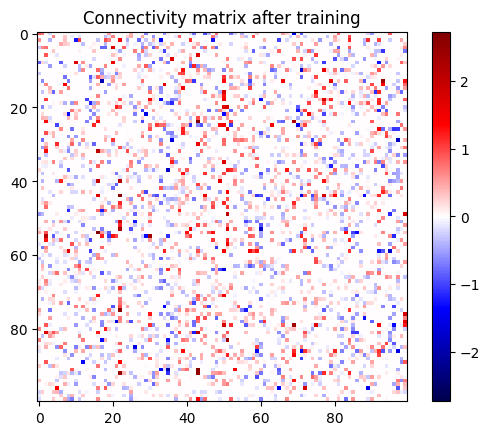

In [14]:
plt.imshow(W_trained, cmap=plt.get_cmap('seismic'), vmin = -(max(-1*np.min(W_trained), np.max(W_trained))), vmax = (max(-1*np.min(W_trained), np.max(W_trained))))
plt.title("Connectivity matrix after training")
plt.colorbar()

C:\Users\sq373\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Clustered connectivity matrix after training')

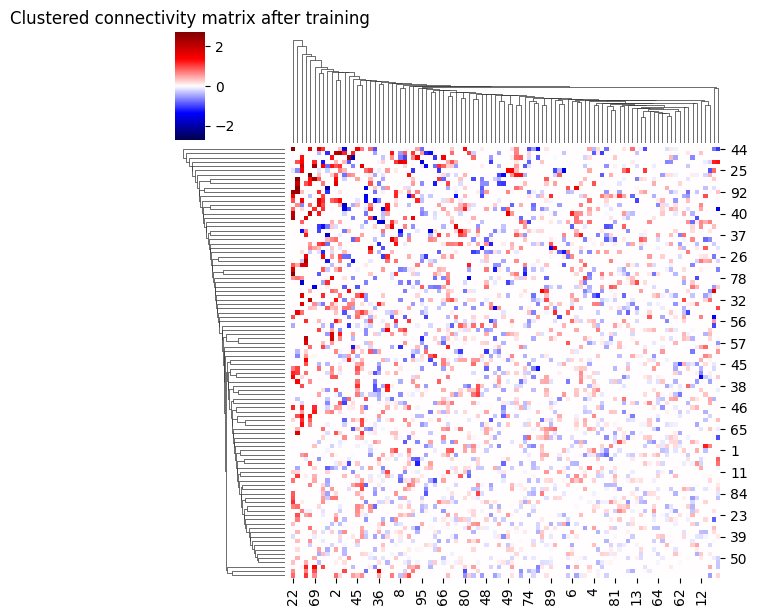

In [15]:
sns.clustermap(W_trained, cmap=plt.get_cmap('seismic'), vmin = -(max(-1*np.min(W_trained), np.max(W_trained))), vmax = (max(-1*np.min(W_trained), np.max(W_trained))), figsize = (6, 6))
plt.title("Clustered connectivity matrix after training")

Text(0.5, 1.0, 'Auxillary targets')

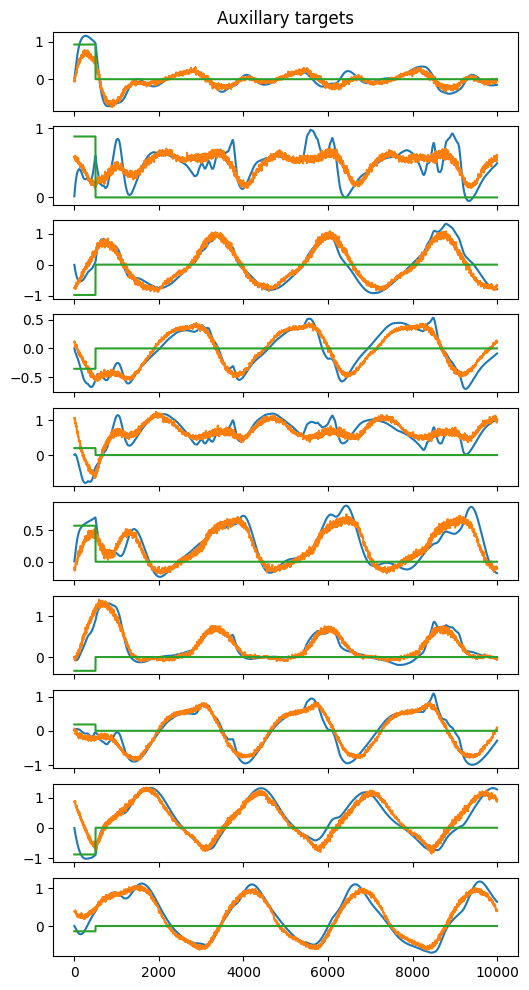

In [23]:
n_plot = 10

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(aux_targs[i])
    axs[i].plot(sdrive_t[i][(nloop - 1)*int(T/dt):nloop*int(T/dt)])
    axs[i].plot(fin[i])

axs[0].set_title("Auxillary targets")

Text(0.5, 1.0, 'Synaptic drive over training')

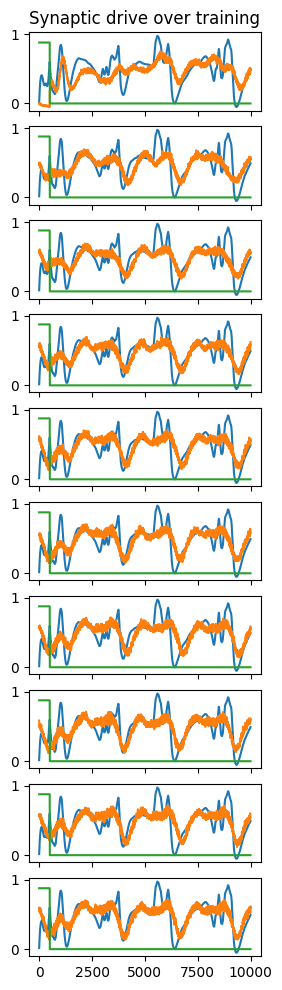

In [25]:
ind = 1

fig, axs = plt.subplots(nloop, 1, figsize = (3, 12), sharex = True)
for i in range(nloop):
    axs[i].plot(aux_targs[ind])
    axs[i].plot(sdrive_t[ind][i*int(T/dt):(i+1)*int(T/dt)])
    axs[i].plot(fin[ind])
axs[0].set_title("Synaptic drive over training")

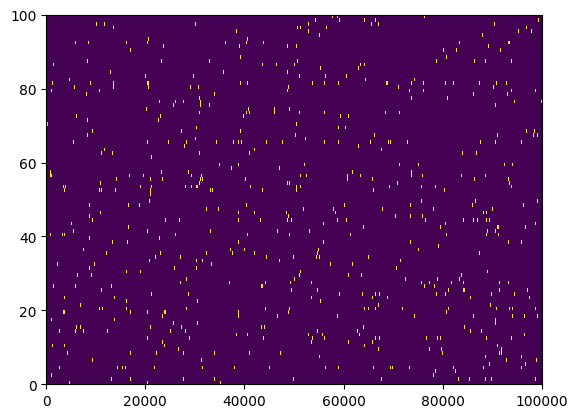

In [26]:
plt.pcolormesh(spk_rast_t)

(0.0, 10000.0)

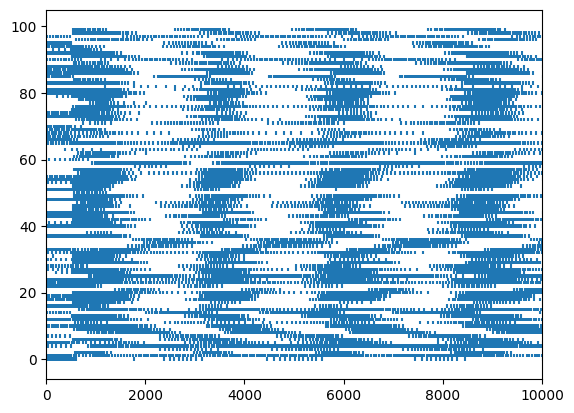

In [33]:
spk_inds, spk_t = np.nonzero(spk_rast_t)
spk_times = []
for idx in np.unique(spk_inds):
    spk_times.append(spk_t[spk_inds == idx])

plt.eventplot(spk_times);
plt.xlim(0, 10000)